In [9]:
#인공신경망이란 (artificial neural network) 여러 입력이 들어오면 각각 가중치를 곱해 더해주고 추가적으로 편차도 더해준다.
#이렇게 다 더한 값을 활성화 함수를 통해서 변형해서 전달하는 단위를 인공 뉴런이라고 한다.
#활성화함수가 없다면 은닉층이 몇개더라도 결국 선형변환이기 때문에 깊은 모델을 만든 의미가 사라진다.
#역전파와 같은 프로세스는 다른 자료를 참고하자
#몇개의 은닉층을 만들어서 비선형 함수를 만들어보자
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

num_data = 1000
num_epoch = 10000

noise = init.normal_(torch.FloatTensor(num_data,1),std=1)
x = init.uniform_(torch.Tensor(num_data,1),-15,15)
y = (x**2) + 3 
y_noise = y + noise

model = nn.Sequential(
    nn.Linear(1,6),
    nn.ReLU(),
    nn.Linear(6,10),
    nn.ReLU(),
    nn.Linear(10,6),
    nn.ReLU(),
    nn.Linear(6,1)
)

loss_func = nn.L1Loss()
optimizer = optim.SGD(model.parameters(),lr = 0.0001)

loss_arr = []
for i in range(num_epoch):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_func(output,y_noise)
    loss.backward()
    optimizer.step()
    loss_arr.append(loss.detach().numpy())

print(loss_arr[-5:])

[array(13.515102, dtype=float32), array(13.513801, dtype=float32), array(13.512492, dtype=float32), array(13.511187, dtype=float32), array(13.509878, dtype=float32)]


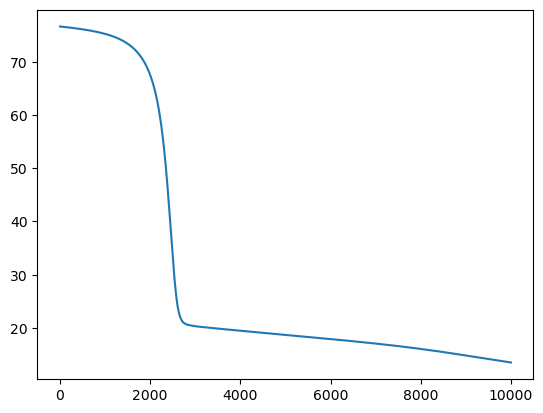

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

In [11]:
#합성곱 신경망
#이론상으로는 인공신경망은 실수 공간에서 연속하는 모든 함수를 근사할 수 있다.
#하지만 무한히 많은 뉴런을 사용하는 네트워크는 만들 수 없고, 만들더라도 cost가 매우 많이 들 것이다.
#또한 이미지와 같은 데이터인 경우 펼치게 된다면 특징이 다 흩어져서 좋은 성능을 보일 수 없다.
#이로 인해서 이미지를 잘 볼 수 있는 CNN(convolutional neural network)가 만들어진다. 
#우리가 책을 위에서 읽고 아래로 내려가는 것 처럼 합성곱 연산은 하나의 필터에 대해서 이미지를 쭉 지나면서 이미지의 부분부분이 필터와 얼마나 연관이 높은지 계산한다.
#즉 하나의 필터와 연관이 높은 부분들을 캐치할 수 있다는 것이다. 
#이 필터의 움직임을 크게할 수 있는게 스트라이드라는 개념이다.
#하나의 이미지에 대해서 여러가지 필터를 사용할 수 있고 필터 하나당 입력 이미지 전체에 대한 필터의 일치 정도가 나오는데, 이를 활성화 지도 또는 feature map이라고 한다.

#입력 이미지 크기가 I 필터 크기가 K stride사이즈가 S라고 할 때 output feature map의 크기는 
#floor{(I-K)/S + 1} 이다 input - 필터 / stride + 1
#또한 연산과정에서 필터(가중치)가 공유되기 때문에 기존 신경망 대비 적은양의 가중치로 학습을 할 수 있다는 장점이 있다.


In [12]:
#필터를 경계선을 추출하는 필터로 적용한다면 이미지에서 물체 간 경계선을 쉽게 찾을 수 있다.
#엠보스 필터를 적용하면 이미지에서 지정한 방향으로 깊이감을 강조해준다. 
#입력과 첫번째 은닉층 사이에 이러한 역할을 하는 필터가 있다면 다양한 특징을 뽑아내서 다음 층으로 보낼 수 있다.
#필터를 통해 뽑아낸 특성들이 중첩됨에 따라 모델은 더 복잡하고 다양한 형태를 구분할 수 있다.
#합성곱 연산을 살펴보면 필터를 적용할 때 마다 output의 사이즈가 점점 작아진다.
#은닉층의 개수 제한이 생기는 것과 동일하고 결과적으로 복잡한 패턴을 학습할 수 없다.
#따라서 padding을 사용해서 크기를 유지한다.
#이렇게 하면 output사이즈는 다음과 같아진다  O = floor{(I-K+2P)/S + 1}
#반대로 이미지의 사이즈가 너무 클 경우 필터를 정말 많이 사용해야한다. 이러면 시간이 오래걸리기 때문에 pooling을 사용한다.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms#이미지를 변환할 수 있음
from torch.utils.data import DataLoader#효율적인 학습을 위해서 데이터를 규칙에 따라 정렬하거나 섞거나

batch_size = 256 #효율적인 학습을 위한 데이터 배치 사이즈 설정
learning_rate = 0.0002
num_epoch = 10


In [3]:
mnist_train = dset.MNIST('./',train=True, transform = transforms.ToTensor(),
                            target_transform=None, download=True)
mnist_test = dset.MNIST('./',train=False, transform = transforms.ToTensor(),
                            target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size = batch_size,shuffle = True, num_workers = 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size = batch_size,shuffle = False, num_workers = 2, drop_last = True)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000